In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense

from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor

2024-08-05 17:39:55.990191: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-05 17:39:56.018802: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
path='/home/hwchoi/001.project/data/T_PATIENTS_DAILY_WHOLE_0731.csv'
df=pd.read_csv(path)
df.head(2)

,sido,create_date,sido_cd,weekend_yn,grid_x,grid_y,sat_x,sat_y,min_ta,max_ta,mean_ta,gap_ta,min_tafeel,max_tafeel,mean_tafeel,gap_tafeel,min_hm,max_hm,mean_hm,gap_hm,min_wbtemp,max_wbtemp,mean_wbtemp,gap_wbtemp,min_ws,max_ws,mean_ws,tropical_3days,heatwave_temp,heatalert_temp,ta_min_3days,ta_max_3days,gap_ta_minmax,popular_man,popular_woman,agriculture_man,agriculture_woman,ta_min_am,ta_max_am,ta_mean_am,ta_min_pm,ta_max_pm,ta_mean_pm,ta_min_six_am1,ta_max_six_am1,ta_mean_six_am1,ta_min_six_am2,ta_max_six_am2,ta_mean_six_am2,ta_min_six_pm1,ta_max_six_pm1,ta_mean_six_pm1,ta_min_six_pm2,ta_max_six_pm2,ta_mean_six_pm2,patientsCnt,instDate,updtDate
0,경기도,2014-05-01,31,0,60,120,NaN,NaN,9.6,24.2,16.6,14.6,12.35,22.04,17.0,9.7,30.0,98.0,61.1,5.4,8.8,14.2,11.6,5.4,0.3,3.5,1.7,0,0,0,9.6,24.2,14.6,6219813,6138017,186278,188594,9,21,13,14,24,20,9.0,13.0,10.0,9,21,15,21,24,22,14,21,17,0,2024-07-31,2024-07-31
1,충청북도,2014-05-01,33,0,69,107,NaN,NaN,10.5,23.7,17.1,13.2,12.78,22.16,17.5,9.4,33.0,91.0,60.0,5.6,9.3,14.9,12.0,5.6,0.0,3.7,1.6,0,0,0,10.5,23.7,13.2,796141,782792,92687,95065,10,21,14,15,23,20,10.0,14.0,12.0,10,21,15,21,23,22,15,22,18,0,2024-07-31,2024-07-31


###  MODELING

#### 1. create_date sorting 적용 케이스

In [4]:
# create_date에 대한 sorting 적용
df['create_date'] = pd.to_datetime(df['create_date'])
df.sort_values(by='create_date', inplace=True)
# 결측치 채우기
df = df.fillna(0)

In [5]:
features=['weekend_yn', 'min_ta', 'max_ta', 'mean_ta', 'gap_ta', 'min_tafeel', 'max_tafeel', 'mean_tafeel', 'gap_tafeel', 'min_hm', 'max_hm', 'mean_hm', 'gap_hm', 'min_wbtemp', 'max_wbtemp', 'mean_wbtemp', 'gap_wbtemp', 'min_ws', 'max_ws', 'mean_ws', 'tropical_3days',
       'heatwave_temp', 'heatalert_temp', 'ta_min_3days', 'ta_max_3days', 'gap_ta_minmax', 'popular_man', 'popular_woman', 'agriculture_man', 'agriculture_woman', 'ta_min_am', 'ta_max_am', 'ta_mean_am', 'ta_min_pm', 'ta_max_pm', 'ta_mean_pm', 'ta_min_six_am1',
       'ta_max_six_am1', 'ta_mean_six_am1', 'ta_min_six_am2', 'ta_max_six_am2', 'ta_mean_six_am2', 'ta_min_six_pm1', 'ta_max_six_pm1', 'ta_mean_six_pm1', 'ta_min_six_pm2', 'ta_max_six_pm2', 'ta_mean_six_pm2']
target='patientsCnt'
print(len(features))

48


In [6]:
# 데이터 스케일링
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

# 학습 데이터와 테스트 데이터로 분할
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=11, shuffle=True)

In [7]:
# RNN 모델 정의 및 학습
def create_rnn_model(input_shape):
    model = Sequential()
    model.add(SimpleRNN(50, activation='relu', input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# LSTM 모델 정의 및 학습
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

In [8]:
# 데이터 형태 변환
X_train_rnn = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_rnn = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))


In [9]:
# RNN 모델 학습
rnn_model = create_rnn_model((1, X_train.shape[1]))
rnn_model.fit(X_train_rnn, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# LSTM 모델 학습
lstm_model = create_lstm_model((1, X_train.shape[1]))
lstm_model.fit(X_train_rnn, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# 예측
y_pred_train_rnn = rnn_model.predict(X_train_rnn).flatten()
y_pred_test_rnn = rnn_model.predict(X_test_rnn).flatten()

y_pred_train_lstm = lstm_model.predict(X_train_rnn).flatten()
y_pred_test_lstm = lstm_model.predict(X_test_rnn).flatten()

Epoch 1/10


/home/hwchoi/anaconda3/envs/kdca/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


521/521 ━━━━━━━━━━━━━━━━━━━━ 1s 881us/step - loss: 4.0543 - val_loss: 4.5717
Epoch 2/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 0s 610us/step - loss: 3.2724 - val_loss: 4.2867
Epoch 3/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step - loss: 3.6548 - val_loss: 4.1519
Epoch 4/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step - loss: 3.2690 - val_loss: 3.9425
Epoch 5/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 0s 620us/step - loss: 2.7753 - val_loss: 3.9393
Epoch 6/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 0s 625us/step - loss: 2.5619 - val_loss: 3.8111
Epoch 7/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 0s 599us/step - loss: 3.2856 - val_loss: 3.6922
Epoch 8/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step - loss: 2.7389 - val_loss: 3.6542
Epoch 9/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step - loss: 2.7338 - val_loss: 3.5493
Epoch 10/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 0s 603us/step - loss: 2.5783 - val_loss: 3.4917
Epoch 1/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 4.0053 - val_loss: 4.4481
Epoch 2/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 0s 7

In [10]:
# 결과 평가
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, r2

In [11]:
# RNN 평가
mae_train_rnn, rmse_train_rnn, r2_train_rnn = evaluate_model(y_train, y_pred_train_rnn)
mae_test_rnn, rmse_test_rnn, r2_test_rnn = evaluate_model(y_test, y_pred_test_rnn)

print("RNN Model:")
print(f'Training MAE: {mae_train_rnn}')
print(f'Training RMSE: {rmse_train_rnn}')
print(f'Training R2: {r2_train_rnn}')
print()
print(f'Test MAE: {mae_test_rnn}')
print(f'Test RMSE: {rmse_test_rnn}')
print(f'Test R2: {r2_test_rnn}')

# LSTM 평가
mae_train_lstm, rmse_train_lstm, r2_train_lstm = evaluate_model(y_train, y_pred_train_lstm)
mae_test_lstm, rmse_test_lstm, r2_test_lstm = evaluate_model(y_test, y_pred_test_lstm)

print("LSTM Model:")
print(f'Training MAE: {mae_train_lstm}')
print(f'Training RMSE: {rmse_train_lstm}')
print(f'Training R2: {r2_train_lstm}')
print()
print(f'Test MAE: {mae_test_lstm}')
print(f'Test RMSE: {rmse_test_lstm}')
print(f'Test R2: {r2_test_lstm}')

RNN Model:
Training MAE: 0.7123146478046607
Training RMSE: 1.651549530633472
Training R2: 0.5026618242263794

Test MAE: 0.7394596215470715
Test RMSE: 1.7324200604323394
Test R2: 0.5052088499069214
LSTM Model:
Training MAE: 0.6885764846688882
Training RMSE: 1.6390236279677983
Training R2: 0.5101771950721741

Test MAE: 0.7095507422332487
Test RMSE: 1.7180391138619822
Test R2: 0.5133893489837646


In [12]:
# RandomForestRegressor 모델 정의 및 학습
rf_model = RandomForestRegressor(random_state=11)
rf_model.fit(X_train, y_train)

# DecisionTreeRegressor 모델 정의 및 학습
dt_model = DecisionTreeRegressor(random_state=11)
dt_model.fit(X_train, y_train)

# 예측
y_pred_train_rf = rf_model.predict(X_train)
y_pred_test_rf = rf_model.predict(X_test)

y_pred_train_dt = dt_model.predict(X_train)
y_pred_test_dt = dt_model.predict(X_test)

# RandomForestRegressor 평가
mae_train_rf, rmse_train_rf, r2_train_rf = evaluate_model(y_train, y_pred_train_rf)
mae_test_rf, rmse_test_rf, r2_test_rf = evaluate_model(y_test, y_pred_test_rf)

print("Random Forest Regressor:")
print(f'Training MAE: {mae_train_rf}')
print(f'Training RMSE: {rmse_train_rf}')
print(f'Training R2: {r2_train_rf}')
print()
print(f'Test MAE: {mae_test_rf}')
print(f'Test RMSE: {rmse_test_rf}')
print(f'Test R2: {r2_test_rf}')

# DecisionTreeRegressor 평가
mae_train_dt, rmse_train_dt, r2_train_dt = evaluate_model(y_train, y_pred_train_dt)
mae_test_dt, rmse_test_dt, r2_test_dt = evaluate_model(y_test, y_pred_test_dt)

print("Decision Tree Regressor:")
print(f'Training MAE: {mae_train_dt}')
print(f'Training RMSE: {rmse_train_dt}')
print(f'Training R2: {r2_train_dt}')
print()
print(f'Test MAE: {mae_test_dt}')
print(f'Test RMSE: {rmse_test_dt}')
print(f'Test R2: {r2_test_dt}')

Random Forest Regressor:
Training MAE: 0.19720876585928487
Training RMSE: 0.49094530977837764
Training R2: 0.9560524360322468

Test MAE: 0.5353940792003076
Test RMSE: 1.2379338120552341
Test R2: 0.7473551937048468
Decision Tree Regressor:
Training MAE: 0.0
Training RMSE: 0.0
Training R2: 1.0

Test MAE: 0.6551326412918108
Test RMSE: 1.7358202370708888
Test R2: 0.5032647054057271


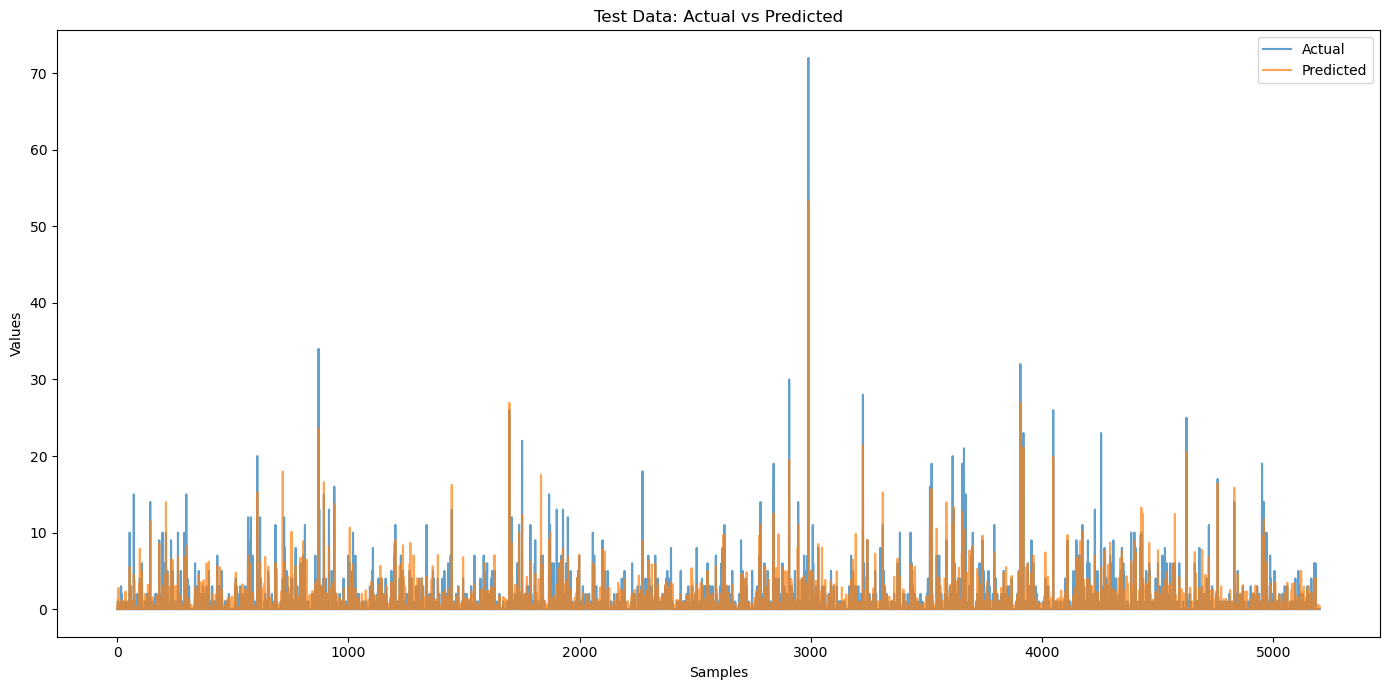

In [19]:
# 실제값과 예측값을 비교하는 라인차트 시각화
plt.figure(figsize=(14, 7))

# Test 데이터에 대한 라인차트
plt.plot(y_test.reset_index(drop=True), label='Actual', alpha=0.7)
plt.plot(y_pred_test_rf, label='Predicted', alpha=0.7)
plt.title('Test Data: Actual vs Predicted')
plt.xlabel('Samples')
plt.ylabel('Values')
plt.legend()

plt.tight_layout()
plt.show()

In [13]:
# 평가 지표 저장
metrics = {
    'Model': ['RNN', 'LSTM', 'Random Forest', 'Decision Tree'],
    'MAE_Train': [mae_train_rnn, mae_train_lstm, mae_train_rf, mae_train_dt],
    'MAE_Test': [mae_test_rnn, mae_test_lstm, mae_test_rf, mae_test_dt],
    'RMSE_Train': [rmse_train_rnn, rmse_train_lstm, rmse_train_rf, rmse_train_dt],
    'RMSE_Test': [rmse_test_rnn, rmse_test_lstm, rmse_test_rf, rmse_test_dt],
    'R2_Train': [r2_train_rnn, r2_train_lstm, r2_train_rf, r2_train_dt],
    'R2_Test': [r2_test_rnn, r2_test_lstm, r2_test_rf, r2_test_dt]
}

metrics_df = pd.DataFrame(metrics)

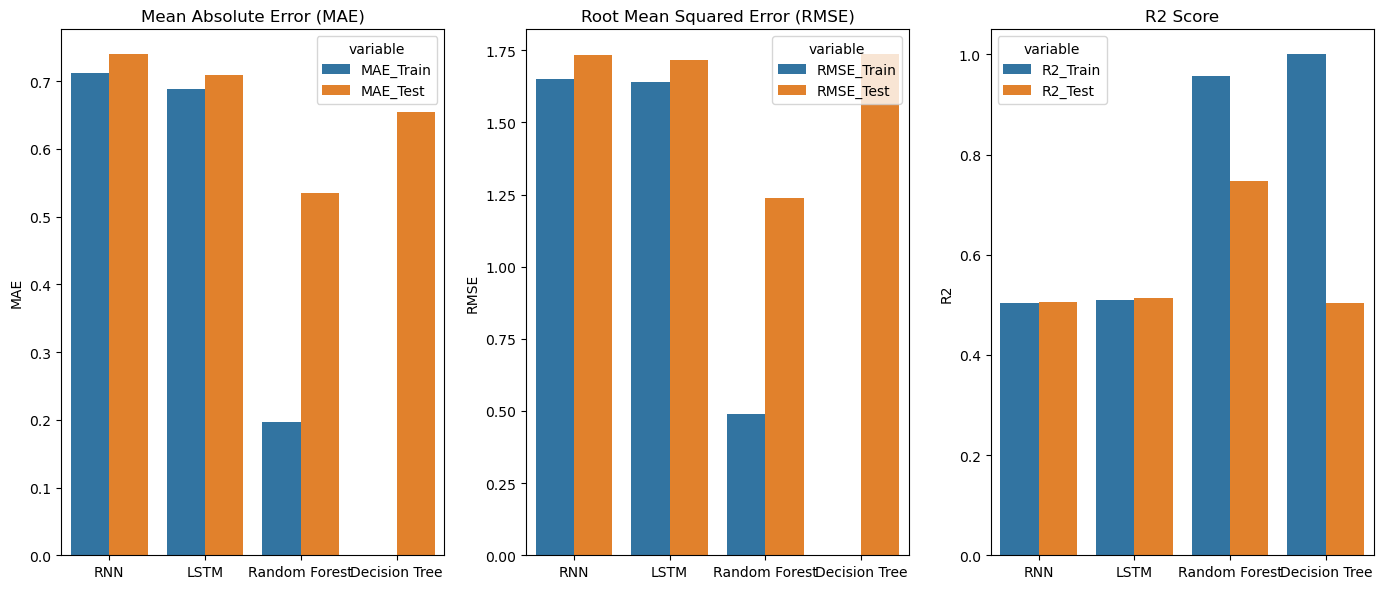

In [14]:
# MAE 시각화
plt.figure(figsize=(14, 6))
plt.subplot(1, 3, 1)
sns.barplot(x='Model', y='value', hue='variable', data=pd.melt(metrics_df, id_vars=['Model'], value_vars=['MAE_Train', 'MAE_Test']))
plt.title('Mean Absolute Error (MAE)')
plt.ylabel('MAE')
plt.xlabel('')

# RMSE 시각화
plt.subplot(1, 3, 2)
sns.barplot(x='Model', y='value', hue='variable', data=pd.melt(metrics_df, id_vars=['Model'], value_vars=['RMSE_Train', 'RMSE_Test']))
plt.title('Root Mean Squared Error (RMSE)')
plt.ylabel('RMSE')
plt.xlabel('')

# R2 시각화
plt.subplot(1, 3, 3)
sns.barplot(x='Model', y='value', hue='variable', data=pd.melt(metrics_df, id_vars=['Model'], value_vars=['R2_Train', 'R2_Test']))
plt.title('R2 Score')
plt.ylabel('R2')
plt.xlabel('')

plt.tight_layout()
plt.show()

In [15]:
# RandomForestRegressor 모델 정의 및 학습
rf_model = RandomForestRegressor(random_state=11)
rf_model.fit(X_train, y_train)

# 예측
y_pred_train_rf = rf_model.predict(X_train)
y_pred_test_rf = rf_model.predict(X_test)

# RandomForestRegressor 평가
mae_train_rf = mean_absolute_error(y_train, y_pred_train_rf)
rmse_train_rf = np.sqrt(mean_squared_error(y_train, y_pred_train_rf))
r2_train_rf = r2_score(y_train, y_pred_train_rf)

mae_test_rf = mean_absolute_error(y_test, y_pred_test_rf)
rmse_test_rf = np.sqrt(mean_squared_error(y_test, y_pred_test_rf))
r2_test_rf = r2_score(y_test, y_pred_test_rf)

print("Random Forest Regressor:")
print(f'Training MAE: {mae_train_rf}')
print(f'Training RMSE: {rmse_train_rf}')
print(f'Training R2: {r2_train_rf}')
print()
print(f'Test MAE: {mae_test_rf}')
print(f'Test RMSE: {rmse_test_rf}')
print(f'Test R2: {r2_test_rf}')

Random Forest Regressor:
Training MAE: 0.19720876585928487
Training RMSE: 0.49094530977837764
Training R2: 0.9560524360322468

Test MAE: 0.5353940792003076
Test RMSE: 1.2379338120552341
Test R2: 0.7473551937048468


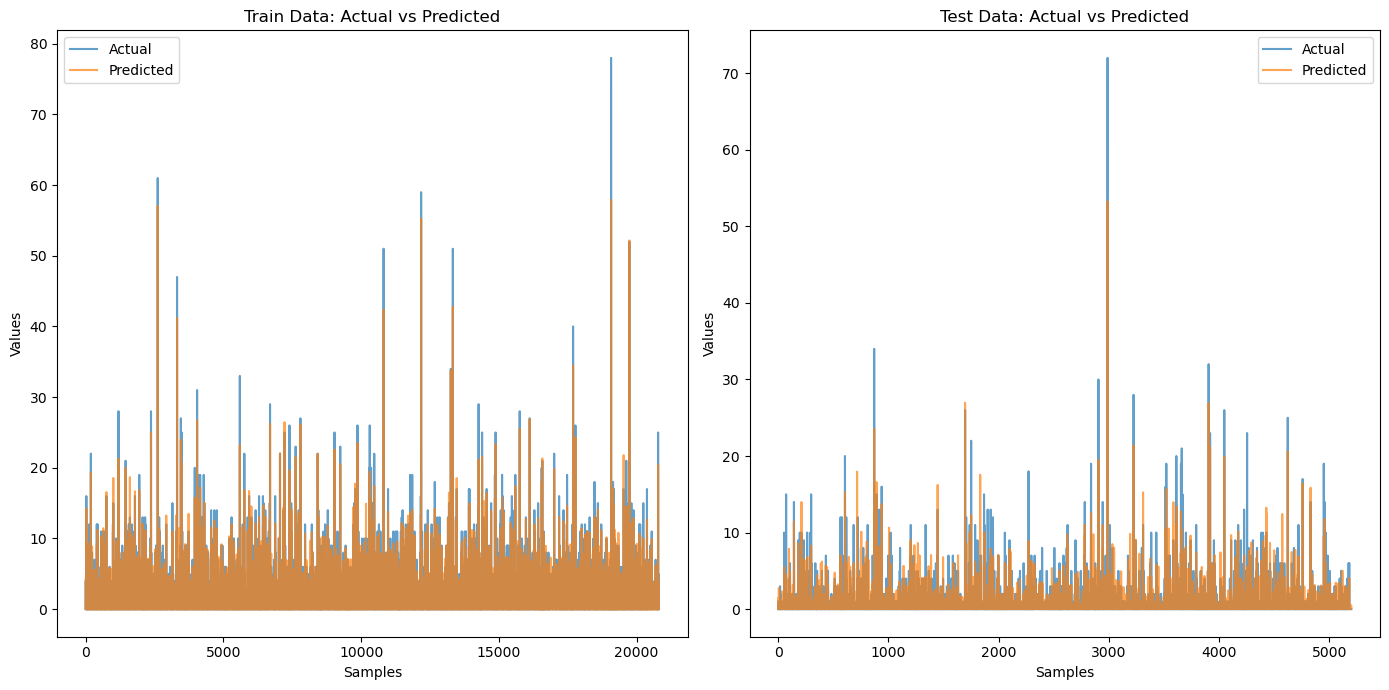

In [16]:
# 실제값과 예측값을 비교하는 라인차트 시각화
plt.figure(figsize=(14, 7))

# Train 데이터에 대한 라인차트
plt.subplot(1, 2, 1)
plt.plot(y_train.reset_index(drop=True), label='Actual', alpha=0.7)
plt.plot(y_pred_train_rf, label='Predicted', alpha=0.7)
plt.title('Train Data: Actual vs Predicted')
plt.xlabel('Samples')
plt.ylabel('Values')
plt.legend()

# Test 데이터에 대한 라인차트
plt.subplot(1, 2, 2)
plt.plot(y_test.reset_index(drop=True), label='Actual', alpha=0.7)
plt.plot(y_pred_test_rf, label='Predicted', alpha=0.7)
plt.title('Test Data: Actual vs Predicted')
plt.xlabel('Samples')
plt.ylabel('Values')
plt.legend()

plt.tight_layout()
plt.show()